# Sawtooth Wave

In this demo, we will make a square using additive synthesis

First, we import what we need

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We'll be processing this as sound, so let's setup our sampling rate \\(f_s\\) in samples per second:

In [4]:
f_s = 44100

## What a real sawtooth looks like

To see how additive synthesis can create a sawtooth wave, first we need to see what a real sawtooth wave looks like. We can do this with `np.tile` where we will append periods of the sawtooth wave together, on after another, to see what comes out.

+ `f_s`: Sample rate
+ `duration_s`: The duration of the waveform in seconds
+ `period_c:` Period of the waveform
+ `periods_in_duration`: The number of periods (sawteeth, if you will) in the entire duration.
+ `samples_per_period`: Given f_s, the number of samples that are present in each period
+ `tiled_sawtooth`: Total sawtooth periods, but rounded up past the period
+ `trimmed_sawtooth`: The awatooth waveform trimmed down to the duration it needs to be at.
+ `waveform`: The resulting waveform at the end.

In [5]:
duration_s = 1.0
f_c = 5.0
period_c = 1.0 / f_c
periods_in_duration = int(np.ceil(duration_s / period_c))
samples_per_period = int(np.ceil(period_c * f_s))
sawtooth_period = np.linspace(1.0, -1.0, samples_per_period)
tiled_sawtooth = np.tile(sawtooth_period, periods_in_duration)
samples_in_duration = int(np.ceil(duration_s * f_s))
waveform = tiled_sawtooth[:samples_in_duration]

Now let's plot it!

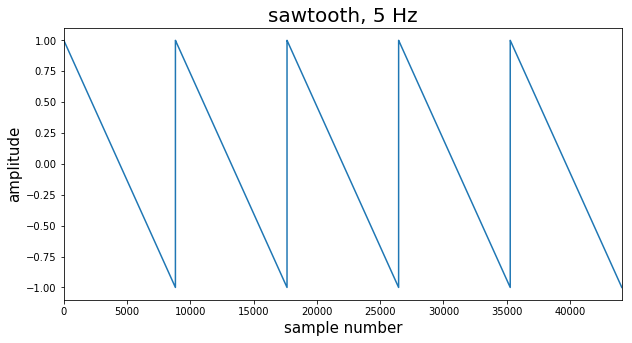

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
xs = np.arange(waveform.shape[0])
ax.set_title('sawtooth, 5 Hz', size=20)
ax.set_xlabel('sample number', size=15)
ax.set_ylabel('amplitude', size=15)
ax.set_xlim(xs.min(), xs.max())
ax.plot(xs, waveform)

# Sawtooth additive synthesis

## Sine waves are the building blocks

Consider the sine wave. We will denote its frequencey as \\(f_c\\). Its amplitude is \\(A_c = 1.0\\). Here we will use a low frequency of \\(f_c = 5 Hz\\), over a period of 1 second, sampled at 44100 samples per second, as we defined above. Recall that our formula for this is:

### Equation 1:

$$ y(t) = A_c sin \Biggl(\frac{2\pi f_c t_i}{f_s}\Biggr) $$

+ \\(A_x\\) is the amplitude.

+ \\(t_i\\) is the sample number, which is an integer.

+ \\(f_s\\) is the sampling rate in units of samples per second, which is an integer.

+ \\(f_c\\) is the frequency of the carrier

Now, in Python

In [9]:
f_c = 5.0
A_c = 1.0
tis = np.arange(0, 1 * f_s)
ys = A_c * np.sin(2 * np.pi * f_c * tis / f_s) 

Now we can plot it

Text(0.5, 1.0, '5.0 Hz sine wave, 44100 samples per second')

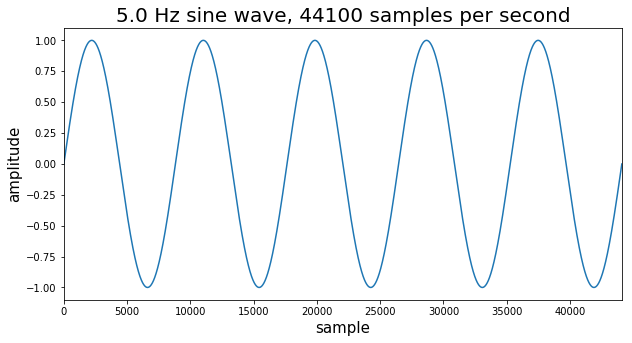

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(tis, ys)
ax.set_xlabel('sample', size=15)
ax.set_ylabel('amplitude', size=15)
ax.set_xlim(tis.min(), tis.max())
ax.set_title('{} Hz sine wave, {} samples per second'.format(f_c, f_s), size=20)

## Sawtooth Wave

The sawtooth wave is a workhorse of subtractive audio synthesis and gives a harsh sound that can be scuplted into notes commonly associated with subtractive synthesis.

See [https://en.wikipedia.org/wiki/Sawtooth_wave](https://en.wikipedia.org/wiki/Sawtooth_wave) for more.

The square wave is constructed by adding together every harmonic in the following fourier series.

#### Equation 4:

$$ x(t) = \frac{2 A}{\pi} \sum_{k=1}^{\infty} (-1)^k \frac{sin(2 \pi kft)}{k} $$

Buat we are calculating samples, so we will implement Eqn 5:

#### Equation 5:

$$ x(t) = \frac{2 A}{\pi} \sum_{k=1}^{\infty} \frac{(-1)^k}{k} \Biggl(\frac{sin(2 \pi kft_i)}{f_s}\Biggr) $$

Note a few things about the equation above:

+ \\(t_i\\) is the sample number, which is an integer.

+ \\(f_s\\) is the sampling rate in units of samples per second, which is an integer.

+ \\(f\\) is the frequency of the **fundamental**

+ \\(k\\) is the multiple of the harmonic, an integer

Remember that we can't generate waveforms that wold exceed our Nyquist rate, so we'll just calculate the first few harmonics.

In [11]:
def sawtooth_wave(fundamental_hz, duration_s=1.0, max_k=2, f_s=44100):
    '''
    Calculate a sawtooth wave as a sum of a sine wave and
    all integer harmonics of the fundamental.
    
    Parameters
    ----------
    fundamental_hz: {float} The frequency of the fundamental in hz
    duration_s: {float} Duration of the waveform
    
    Returns
    -------
    result: {(waveform, harmonics_hz, components_arr)} A tuple containing 
            the summed waveform as the
            first element, the list of harmonics as the second element
            and all the individual components as the third element.
    '''
    harmonics_hz = []
    components_list = []
    ks = np.arange(1, max_k)
    t_is = np.arange(duration_s * f_s)
    
    for k in ks:
        harmonics_hz.append(k * fundamental_hz)
        component = (-1)**k * np.sin(2 * np.pi * k * fundamental_hz * t_is / f_s) / k
        component = component.reshape(1, -1)
        components_list.append(component)
    
    components_arr = np.vstack(components_list)
    waveform = 2 / np.pi * components_arr.sum(axis=0)
    return (waveform, harmonics_hz, components_arr)

## Plotting function

In [12]:
def plot_waveforms(waveform_tpl):
    '''
    Plots the additive waveform as specified in the tuple.
    
    Parameters
    -------
    result: {(waveform, harmonics_hz, components_arr)} A tuple containing 
            the summed waveform as the
            first element, the list of harmonics as the second element
            and all the individual components as the third element. hz
    
    Returns
    -------
    None (but it does plot the waveform)
    '''
    waveform, harmonics_hz, components_arr = waveform_tpl
    y_min = 1.5 * components_arr.min()
    y_max = 1.5 * components_arr.max()
    t_is = np.arange(44100)
    fig, axs = plt.subplots(nrows=len(harmonics_hz) + 1, ncols=1, figsize=(15, 20), sharex=True)
    plt.tight_layout()
    axs = axs.flatten()
    axs[0].set_xlim(t_is.min(), t_is.max())
    
    axs[0].set_ylim(y_min, y_max)
    axs[0].plot(t_is, waveform, color='r')
    axs[0].set_title('Total Waveform'.format(harmonics_hz[0]), size=20)
    
    for i, harmonic_hz, component in zip(range(len(harmonics_hz)), harmonics_hz, components_arr):
        axs[i + 1].set_ylim(y_min, y_max)
        axs[i + 1].plot(t_is, component)
        axs[i + 1].set_title('{} hz'.format(harmonic_hz))

### Create the sawtooth waveform and plot it

Using our function for plotting from above.

Turn it up to the 11th harmonic.

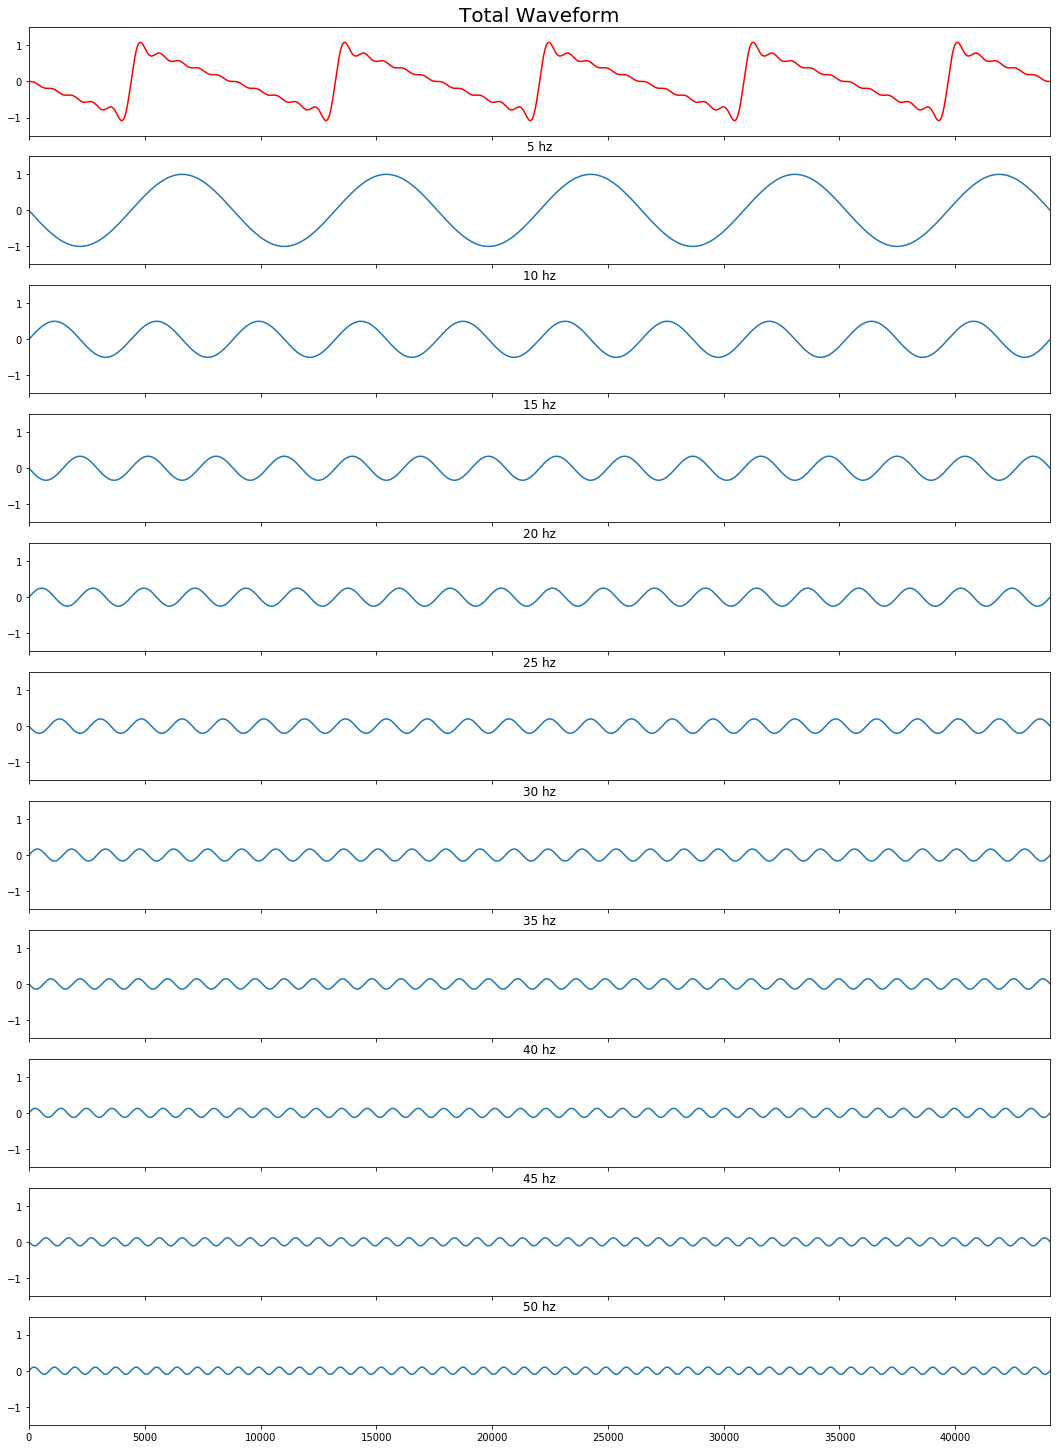

In [16]:
result = sawtooth_wave(5, 1.0, 11)
plot_waveforms(result)